In [ ]:
"""TEST FOR RANDOM STUFF"""

In [1]:
import numpy as np
from pathlib import Path
import utils
import mne
from scipy.stats import pearsonr
import scipy
from torch_geometric.utils import from_networkx
from torch_geometric_temporal import StaticGraphTemporalSignal, DynamicGraphTemporalSignal
import networkx as nx
from matplotlib import pyplot as plt

In [5]:
""""ACHTUNG czas do ataku jest podawany źle dla pierwszej próbki"""

'"ACHTUNG czas do ataku jest podawany źle dla pierwszej próbki'

In [ ]:
recording_features_array,recording_labels_array,recording_timestep_array = utils.extract_training_data_and_labels

In [2]:
data_preprocessed = mne.io.read_raw_edf(Path('data/preprocessed_data/chb09/chb09_08.edf'), preload=False, verbose=False)
#input_array = data_preprocessed.get_data()

In [7]:
data_preprocessed

<RawEDF | chb09_08.edf, 18 x 3686400 (14400.0 s), ~22 kB, data not loaded>

In [10]:
sfreq = 256

In [17]:
seizure = data_preprocessed.get_data(start = 2951*sfreq,stop=3030*sfreq)
normal = data_preprocessed.get_data(start = 2861*sfreq,stop=2940*sfreq)

In [18]:
normal.shape

(18, 20224)

In [16]:
fig, axs = plt.subplots(18,1)
for n,ax in enumerate(axs):
    ax.plot(seizure[n])
plt.show()

qt.qpa.wayland: Wayland does not support QWindow::requestActivate()


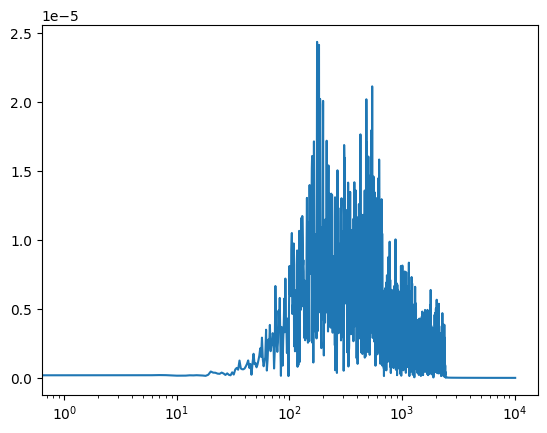

In [86]:

T = 1
F = 15
Fs = 5000
Ts = 1./Fs
N = int(T/Ts)

t = np.linspace(0, T, N)
signal = seizure[0]
signal_samples = signal.shape[0]
sp = np.fft.fft(signal)
amplitudes = 2 / signal_samples * np.abs(sp) 
freq = np.fft.fftfreq(signal_samples) * signal_samples * 1 / (T - 0)

plt.semilogx(freq[:len(freq) // 2], amplitudes[:len(sp) // 2])
#plt.plot(t, signal)
plt.show()

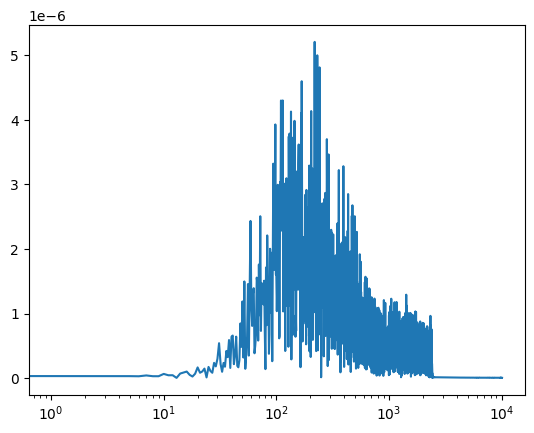

In [87]:
T = 1
F = 15
Fs = 5000
Ts = 1./Fs
N = int(T/Ts)

t = np.linspace(0, T, N)
signal = normal[0]
signal_samples = signal.shape[0]
sp = np.fft.fft(signal)
amplitudes = 2 / signal_samples * np.abs(sp) 
freq = np.fft.fftfreq(signal_samples) * signal_samples * 1 / (T - 0)

plt.semilogx(freq[:len(freq) // 2], amplitudes[:len(sp) // 2])
#plt.plot(t, signal)
plt.show()

In [84]:
signal.shape

(20224,)

In [ ]:
np.square()

In [46]:
%matplotlib inline

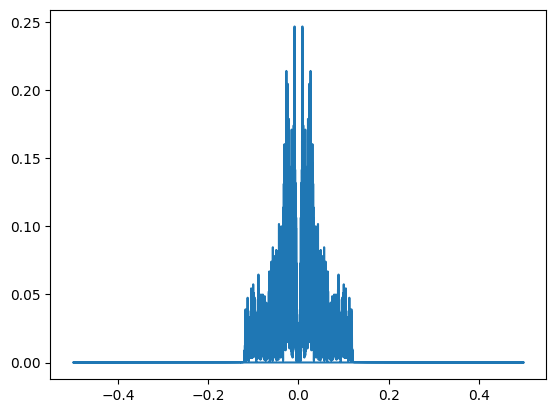

In [53]:
t = seizure[0]

sp = np.fft.fft(t)

freq = np.fft.fftfreq(t.shape[-1])

plt.plot(freq, np.sqrt(np.square(sp.real) + np.square(sp.imag)))

In [41]:
freq

array([ 0.00000000e+00,  4.94462025e-05,  9.88924051e-05, ...,
       -1.48338608e-04, -9.88924051e-05, -4.94462025e-05])

In [23]:
np.sin(t).shape

(256,)

In [26]:
freq.shape

(256,)

In [22]:
sp.shape

(256,)

In [19]:
fig, axs = plt.subplots(18,1)
for n,ax in enumerate(axs):
    ax.plot(normal[n])
plt.show()

qt.qpa.wayland: Wayland does not support QWindow::requestActivate()
qt.qpa.wayland: Wayland does not support QWindow::requestActivate()


In [4]:
%matplotlib qt

QSocketNotifier: Can only be used with threads started with QThread


libEGL warning: MESA-LOADER: failed to open iris: /usr/lib/dri/iris_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

libEGL warning: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)

qt.qpa.wayland: Failed to initialize EGL display 3001
qt.qpa.wayland: Wayland does not support QWindow::requestActivate()


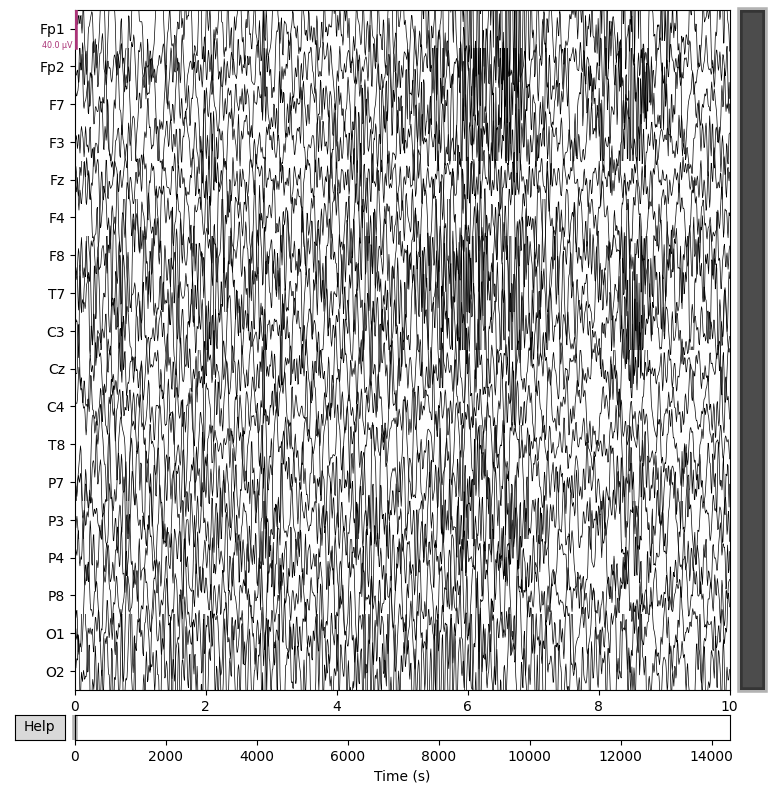

Channels marked as bad:
none


In [5]:
data_preprocessed.plot()

In [5]:
data = data_preprocessed.get_data()

In [6]:
import os 
import pandas as pd
def _load_csv_table_events(table_path):
        event_dict = pd.read_csv(table_path).to_dict('index')
        return event_dict
def _get_event_tables(patient_name,event_tables_path):
        event_table_list = os.listdir(event_tables_path)
        patient_start_table, patient_stop_table = [os.path.join(event_tables_path,ev_table)
        for ev_table in event_table_list if patient_name in ev_table]
        start_events_dict = _load_csv_table_events(patient_start_table)
        stop_events_dict = _load_csv_table_events(patient_stop_table)
        return start_events_dict,stop_events_dict
        
def _get_recording_events(events_dict,recording):
    recording_list = list(events_dict[recording+'.edf'].values())
    recording_events = [int(x) for x in recording_list if not np.isnan(x)]
    return recording_events

In [7]:
event_tables = _get_event_tables("chb21",r"A:\Sano\sano_eeg\event_tables")
start_event_tables = _get_recording_events(event_tables[0],"chb21_19") # get start events
stop_event_tables = _get_recording_events(event_tables[1],"chb21_19") # get stop events

In [8]:
def get_edges(features):

    graph = nx.complete_graph(features.shape[1])
    self_loops = [[node,node]for node in graph.nodes()]
    graph.add_edges_from(self_loops)
    edges = np.expand_dims(from_networkx(graph).edge_index.numpy(),axis=0)
    return np.repeat(edges,features.shape[0],axis=0)


In [9]:
def plv_connectivity(sensors,data):
    """
    Parameters
    ----------
    sensors : INT
        DESCRIPTION. No of sensors used for capturing EEG
    data : Array of float 
        DESCRIPTION. EEG Data
    
    Returns
    -------
    connectivity_matrix : Matrix of float
        DESCRIPTION. PLV connectivity matrix
    connectivity_vector : Vector of flaot 
        DESCRIPTION. PLV connectivity vector
    """
    print("PLV in process.....")
    
    # Predefining connectivity matrix
    connectivity_matrix = np.zeros([sensors,sensors],dtype=float)
    
    # Computing hilbert transform
    data_points = data.shape[-1]
    data_hilbert = np.imag(scipy.signal.hilbert(data))
    phase = np.arctan(data_hilbert/data)
    
    # Computing connectivity matrix 
    for i in range(sensors):
        for k in range(sensors):
            connectivity_matrix[i,k] = np.abs(np.sum(np.exp(1j*(phase[i,:]-phase[k,:]))))/data_points
            
    # Computing connectivity vector
    connectivity_vector = connectivity_matrix[np.triu_indices(connectivity_matrix.shape[0],k=1)] 
      
    # returning connectivity matrix and vector
    print("PLV done!")
    return connectivity_matrix

In [10]:
features,labels,time_labels = utils.extract_training_data_and_labels(
                    data,
                    start_event_tables,
                    stop_event_tables,
                    fs = 256,
                    seizure_lookback = 600,
                    sample_timestep = 10,
                    overlap = 0,
                )

In [11]:
edges = get_edges(features)
plv_matrix = plv_connectivity(18,data)

PLV in process.....
PLV done!


In [12]:
graph = nx.complete_graph(18)

self_loops = [[node,node]for node in graph.nodes()]
graph.add_edges_from(self_loops)
garph_dict = {}

for edge in graph.edges():
    e_start,e_end = edge
    garph_dict[edge] = {'plv':plv_matrix[e_start,e_end]}
nx.set_edge_attributes(graph, garph_dict)
final_graph = from_networkx(graph)

In [13]:
edge_weights = np.expand_dims(final_graph.plv.numpy(),axis=0)
edge_weights = np.repeat(edge_weights,repeats=features.shape[0],axis=0)
edges = get_edges(features)


In [14]:
labels = labels.astype(np.int32)
time_ints = time_labels.astype(np.int32)

In [46]:
labels = labels.reshape((65,1))
time_labels = time_labels.reshape(1,65).astype(np.int32)

In [47]:
time_labels

array([[590, 580, 570, 560, 550, 540, 530, 520, 510, 500, 490, 480, 470,
        460, 450, 440, 430, 420, 410, 400, 390, 380, 370, 360, 350, 340,
        330, 320, 310, 300, 290, 280, 270, 260, 250, 240, 230, 220, 210,
        200, 190, 180, 170, 160, 150, 140, 130, 120, 110, 100,  90,  80,
         70,  60,  50,  40,  30,  20,  10,   0,   0,   0,   0,   0,   0]])

In [61]:
data_loader = DynamicGraphTemporalSignal(edges,list(edge_weights),features,labels, time_ints)

TypeError: DynamicGraphTemporalSignal.__init__() takes 5 positional arguments but 6 were given

In [55]:
snapshot=data_loader.__getitem__(1)
print(snapshot.time_labels)

tensor([2703401323856, 2702667896112, 2703401329376, 2702667896112,
        2703401329536, 2702667896112, 2703401331296, 2702667896112,
        2703253335824, 2702667896112, 2703401326336, 2702667896112,
        2703401324176, 2702667896112, 2703401332896, 2702667896112,
        2703401323776, 2702667896112, 2703401324016, 2702667896112,
        2703401334816, 2702667896112, 2703400803008, 2702667896112,
        2703400803808, 2702667896112, 2703400803168, 2702667896112,
        2703400801568, 2702667896112, 2703400805088, 2702667896112,
        2703400800288, 2702667896112, 2703400800688, 2702667896112,
        2703400800928, 2702667896112, 2703400804768, 2702667896112,
        2703400804288, 2702667896112, 2703400803888, 2702667896112,
        2703400804528, 2702667896112, 2703400805888, 2702667896112,
        2703400806528, 2702667896112, 2703400805648, 2702667896112,
        2703400806128, 2702667896112, 2703400806608, 2702667896112,
        2703400806448, 2702667896112, 2703400801

In [ ]:
def calculate_pearson_correlation(eeg_array):
    for n,channel in enumerate(eeg_array):
        for p,channel2 in enumerate(eeg_array):
            print(f'Correlation of {n} and {p} is {pearsonr(channel,channel2)}')


In [ ]:
calculate_pearson_correlation(data)

In [ ]:
plv_matrix, plv_vector = plv_connectivity(18,data)

In [ ]:
plv_vector.shape

In [ ]:
phase1 = np.angle(np.fft.fft(sig1))
phase2 = np.angle(np.fft.fft(sig2))

In [ ]:
phase_synchrony = 1-np.sin(np.abs(phase1-phase2)/2)

In [ ]:
def phase_locking_value(theta1, theta2):
    phase1 = np.angle(np.fft.fft(theta1))
    phase2 = np.angle(np.fft.fft(theta2))
    phase_synchrony = 1-np.sin(np.abs(phase1-phase2)/2)
    complex_phase_diff = np.exp(np.complex(0,1)*(phase_synchrony))
    plv = np.abs(np.sum(complex_phase_diff))/len(theta1)
    return plv

In [ ]:
def calculate_plv_correlation(eeg_array):
    for n,channel in enumerate(eeg_array):
        for p,channel2 in enumerate(eeg_array):
            print(f'Correlation of {n} and {p} is {phase_locking_value(channel,channel2)}')

In [ ]:
calculate_plv_correlation(data)

In [ ]:
data_preprocessed._data.shape

In [ ]:
start_ev = np.array([1288,2000])
end_ev = np.array([1344,2100])


In [ ]:

features,labels,time_labels = utils.extract_training_data_and_labels(input_array,start_ev,end_ev,overlap=0)

In [ ]:
list_feats = features.tolist()

In [ ]:
features.shape

In [ ]:
np.array(list_feats).shape

In [ ]:
adult_data =Path('raw_dataset')
peprocessed_data = Path('preprocessed_data')
subject_seizures = Path('raw_dataset/RECORDS-WITH-SEIZURES')

In [ ]:
utils.preprocess_dataset(subject_seizures,adult_data,peprocessed_data)

In [ ]:
data_raw =utils.load_and_dump_channels(Path('raw_dataset/chb01/chb01_03.edf'))
utils.reorder_channels_chbmit(data_raw)
raw_copy = utils.run_preprocessing(data_raw,18,apply_ica=False,apply_pca = True,freq_l=2)